## Introduction
This notebook is made for training and making predictions for our golf ball prediction project.  
This is a project where we want to get a lot of prediction data out of a video where a person hits a golf ball.


For this part of the project we will be matching the data we get from the videos with the data from simulations we ran.  
To do this we are going to use Tensorflow, more specifically a deep learning API running on top of Tensorflow called `Keras`.  


At the end of this notebook we will have a trained model and we will be able to make a prediction of how hard you hit a golf ball (and some other data) on all of the video data we put in to the model.

**Make sure to use an environment with <a href="https://www.tensorflow.org/install">Tensorflow</a> and <a href="https://matplotlib.org/stable/users/installing/index.html">matplotlib</a> installed.**


### Table of contents
1. Imports
1. Get dataset
1. Make or import the model
1. Train the model
1. Get plot from history
1. Save the model
1. Predict something

## 1. Imports

In [1]:
import os

import numpy as np
import tensorflow as tf
import json
from matplotlib import pyplot as plt
from keras.callbacks import ModelCheckpoint

## 2. Get dataset

This function will get data from the folder "datasets" and convert every json file to <a href="https://www.tensorflow.org/api_docs/python/tf/Tensor">Tensorflow Tensors</a>.  
We need these Tensors because that is an expected input for training the model later.

Because the json array we get is a nested array we need to "flatten" the data first, we do this using a <a href="https://www.tensorflow.org/api_docs/python/tf/nest/flatten">Tensorflow flatten function</a>  
After the input is flattened you can simply <a href="https://www.tensorflow.org/api_docs/python/tf/convert_to_tensor">convert to tensor</a> and use this tensor as an input or output when training the model.

In [2]:
directory = os.path.join(os.getcwd(), "datasets")
all_input_files = np.array([])

for filename in os.listdir(directory):
    if filename.endswith(".json"):
        all_input_files = np.append(all_input_files, filename)
    else:
        continue

input = []
output = []
for i in range(len(all_input_files)):
    x = json.load(open(os.path.join(directory, all_input_files[i])))

    print(f"input {i}:", x["inputs"], "\n")
    print(f"flattened input {i}:", tf.nest.flatten(x["inputs"]), "\n")

    input.append(tf.nest.flatten(x["inputs"]))
    output.append(tf.nest.flatten(x["outputs"]))

train_ds_input = tf.convert_to_tensor(input)
train_ds_output = tf.convert_to_tensor(output)

print("tensor input:", train_ds_input)


input 0: [{'time': 1, 'coordinatesInput': {'x1': 1, 'x2': 2, 'y1': 1, 'y2': 2}}, {'time': 2, 'coordinatesInput': {'x1': 2, 'x2': 3, 'y1': 2, 'y2': 3}}, {'time': 3, 'coordinatesInput': {'x1': 3, 'x2': 4, 'y1': 3, 'y2': 4}}, {'time': 4, 'coordinatesInput': {'x1': 4, 'x2': 5, 'y1': 4, 'y2': 5}}] 

flattened input 0: [1, 2, 1, 2, 1, 2, 3, 2, 3, 2, 3, 4, 3, 4, 3, 4, 5, 4, 5, 4] 

tensor input: tf.Tensor([[1 2 1 2 1 2 3 2 3 2 3 4 3 4 3 4 5 4 5 4]], shape=(1, 20), dtype=int32)


## 3. Make or import the model
This function will either:
* Import a model if it exists in the models folder
* Create a new model

In [3]:
if os.path.exists(os.path.join(os.getcwd(), "./models/model.h5")):
    model = tf.keras.models.load_model(os.path.join(os.getcwd(), "./models/model.h5"))
    print("Model loaded")
else:
    inputs = tf.keras.Input(shape=(20,), name="inputs")
    x = tf.keras.layers.Dense(20, activation=tf.nn.relu)(inputs)
    outputs = tf.keras.layers.Dense(21, activation=tf.nn.softmax)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
    print("Model created")

Model loaded


## 4. Train the model

### Make callbacks
First we need to make callbacks.  
We log the training process in the "logs" folder.  
We also make checkpoints everytime the accuracy increases so we can load that later if something happens like the machine crashes.

In [4]:
filepath="./models/weights-improvement-{epoch:02d}.hdf5"

my_callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max'),
]

### Train the model
Here we get to actually train the model.

We use the `train_ds_input` and `train_ds_output` we made in an earlier code block. This is the training data.  
For now there is 100 epochs and 100 steps_per_epoch this can be changed anytime. For now I will leave it like this since there is only 2 inputs and it will not train very well yet.  
We also need to set the callbacks to `my_callbacks` we made in the above code cell.

In [5]:
history = model.fit(train_ds_input, train_ds_output, epochs=100, steps_per_epoch=100, batch_size=8000, callbacks=my_callbacks)

Epoch 1/100
100/100 [==============================] - 1s 5ms/step - loss: -66181.3906 - accuracy: 1.0000

Epoch 00001: accuracy improved from -inf to 1.00000, saving model to ./models\weights-improvement-01.hdf5
Epoch 2/100
100/100 [==============================] - 0s 210us/step - loss: -66181.3906 - accuracy: 1.0000

Epoch 00002: accuracy did not improve from 1.00000


## 5. Get plot from history
From the training process we get all sorts of data we can use to plot to visualize how well the model has trained.

In this function we make a plot using matplotlib using the `history` from the model training.

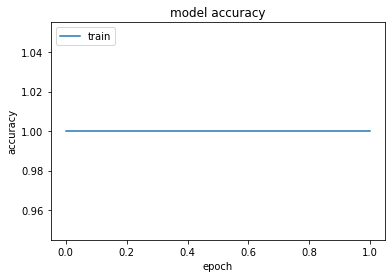

In [6]:
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_acc']) # TODO: add validation accuracy
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 6. Save the model
The model is done training and we can save it now, this way we dont have to use checkpoints each time.  
This model is reusable for next time we want to maybe train it better or make a prediction.

In [7]:
model.save("./models/model.h5")

## 7. Predict something
At last we can make a prediction.  
The prediction itself is not very readable since it is still a flattened array.  
To make the prediction a bit more readable we can use a Tensorflow function <a href="https://www.tensorflow.org/api_docs/python/tf/nest/pack_sequence_as">tf.nest.pack_sequence_as()</a>.  
In this function we use the original structure for the output.

See <a href="predict.py">predict.py</a> for more detailed code.  
Right here we only go through all the files in the datasets directory and make a prediction. For other predictions just **import predict** and use the `predict` function to make a prediction of a video.

In [9]:
import predict

directory = os.path.join(os.getcwd(), "datasets")
for filename in os.listdir(directory):
    if filename.endswith(".json"):
        x = json.load(open(os.path.join(directory, filename)))
        print(predict.predict(x["inputs"]))
    else:
        continue

Model loaded
{'speed': 0.0, 'angle': 0.0, 'spinAxis': 0.0, 'distance': 0.0, 'rpm': 1.0, 'resultData': [{'time': 0.0, 'coordinatesOutput': {'x': 0.0, 'y': 0.0, 'z': 0.0}}, {'time': 0.0, 'coordinatesOutput': {'x': 0.0, 'y': 0.0, 'z': 0.0}}, {'time': 0.0, 'coordinatesOutput': {'x': 0.0, 'y': 0.0, 'z': 0.0}}, {'time': 0.0, 'coordinatesOutput': {'x': 0.0, 'y': 0.0, 'z': 0.0}}]}
